# Analyzing CIA Factbook Data Using SQL
***
## Introduction
In this project, we're going to analyze data from the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/) (2015), a compendium of statistics about all of the countries on Earth. The Factbook contains various demographic and geographic information, like the global population, the annual population growth rate, the total land and water area, and so on. The SQLite `factbook.db` database can be downloaded [here](https://dsserver-prod-resources-1.s3.amazonaws.com/257/factbook.db).
### Summary of Results
The most <strong>populated</strong> countries are China, India, the United States, Indonesia, and Brazil; the least populated are some islands and Vatican. The highest <strong>population density</strong> is observed in Macau, Monaco, Singapore, and Hong Kong; from bigger countries – Bangladesh and South Korea. The lowest population density: Greenland and Svalbard; from bigger countries – Mongolia, Namibia, and Australia. <strong>African countries</strong> show the highest both birth rate (together with <strong>Iraq</strong> and <strong>Afganistan</strong>) and death rate (as well as <strong>Afganistan</strong>), with the birth rates much higher and resulting in the highest values of the natural increase and population growth in the world. In <strong>Western Europe</strong>, some many countries (Monaco, Andorra, Germany, Greece, Italy, and Portugal) demonstrate low birth rates, leading to a negative natural increase and low population growth. In <strong>Eastern Europe</strong>, <strong>Baltic countries</strong>, and <strong>Russia</strong>, a negative natural increase is caused in some cases (Bosnia and Herzegovina, Slovenia, Romania) by low birth rates, in some other (Ukraine, Belarus, Baltic countries, Russia) – by high death rates, and in the others (Bulgaria, Serbia, Hungary) - by both. The <strong>Middle East</strong> countries show the lowest death rates in the world. <strong>Japan</strong>, <strong>Saint Pierre and Miquelon</strong>, and <strong>South Korea</strong> have one of the lowest birth rates in the world, leading to a negative natural increase. The biggest countries by <strong>area</strong> are Russia, Canada, the United States, China, and Brazil; the smallest ones: Vatican and Monaco. The countries with the highest <strong>water-to-land ratio</strong> are Malawi, Netherlands, and Uganda.    
## Connecting to the Database

In [35]:
#!conda install -yc conda-forge ipython-sql

In [36]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db    

## Data Overview
We'll start by getting information on the tables in the database.

In [37]:
%%sql
SELECT *
  FROM sqlite_master
WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


In [38]:
%%sql
SELECT *
  FROM sqlite_sequence;

 * sqlite:///factbook.db
Done.


name,seq
facts,261


Hence, apart from an internal automatically created table `sqlite_sequence`, we have a table called `facts` with 261 rows, with which we'are going to work in this project. 

Let's have a look at the first five rows.

In [39]:
%%sql
SELECT *
  FROM facts
LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


The `facts` table contains demographic and geographic data about all the countries. Since the table counts 261 rows, and  since in 2015 (the year when this factbook was released) there were [198 countries](https://en.wikipedia.org/wiki/List_of_countries_by_population_in_2015), some of the rows must represent other territories or administrative units rather than countries.

The column names are mostly self-explanatory; below are the descriptions for those less evident:
- `area_land` – the country's land area in km2,
- `area_water` – the country's water area in km2,
- `population_growth`– the country's population growth in %,
- `birth_rate` – the number of births per year per 1,000 people,
- `death_rate` – the number of deaths per year per 1,000 people,
- `migration_rate` – the difference between the number of persons entering (immigrants) and leaving (emigrants) a country during the year, per 1,000 people.

## Exploring Population Statistics
Let's calculate some summary statistics for `population` and look for any outlier countries.

In [40]:
%%sql
SELECT MIN(population) AS min_population,
       MAX(population) AS max_population,      
       AVG(population) AS average_population
    FROM facts;

 * sqlite:///factbook.db
Done.


min_population,max_population,average_population
0,7256490011,62094928.32231405


We clearly see 2 issues here: there is at least one country or territory with the population equal to 0, and one with the population of 7.26 bln people, that seems to be the [world population in 2015](https://population.un.org/wpp/Publications/Files/WPP2015_DataBooklet.pdf). Let's check the names of these territories.

In [41]:
%%sql
SELECT name, population
  FROM facts
WHERE population = (
        SELECT MIN(population) 
          FROM facts)
    OR population = (
        SELECT MAX(population) 
          FROM facts);

 * sqlite:///factbook.db
Done.


name,population
Antarctica,0
World,7256490011


Hence, we can confirm that the maximum value of `population` just corresponds to the world population in 2015, represented by its own row in the table. The minimum value, instead, is related to Antarctica, which also looks reasonable, since, according to the [CIA Factbook page for Antarctica](https://www.cia.gov/library/publications/the-world-factbook/geos/ay.html), there are 
> no indigenous inhabitants, but there are both permanent and summer-only staffed research stations

Let's recalculate the summary statistics excluding these outliers.

In [42]:
%%sql
SELECT MIN(population) AS min_population,
       MAX(population) AS max_population,      
       ROUND(AVG(population), 0) AS average_population
    FROM facts
WHERE name != 'Antarctica' 
  AND name != 'World';

 * sqlite:///factbook.db
Done.


min_population,max_population,average_population
48,1367485388,32377011.0


Now the minimum and maximum values look much more plausible. Also, the average population, without the outliers, decreased almost twice.

Let's find out what countries have the biggest and the smallest populations. This time, instead of looking only for the countries with the extreme values of `population`, we'll have a look at the TOP5 and BOTTOM5 countries.

In [43]:
%%sql
SELECT name, population AS top5_population
  FROM facts
WHERE name != 'World'
ORDER BY population DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,top5_population
China,1367485388
India,1251695584
European Union,513949445
United States,321368864
Indonesia,255993674


One more issue appears here: the European Union is not a country, we have to exclude also this.

In [44]:
%%sql
SELECT name, population AS top5_population
  FROM facts
WHERE name != 'World' 
  AND name != 'European Union'
ORDER BY population DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,top5_population
China,1367485388
India,1251695584
United States,321368864
Indonesia,255993674
Brazil,204259812


We see that the <u>most populated</u> country is <strong>China</strong> (which is a common knowledge fact), followed by <strong>India</strong>, then with a big gap by the <strong>United States</strong>, <strong>Indonesia</strong>, and <strong>Brazil</strong>.

In [45]:
%%sql
SELECT name, population AS bottom5_population
  FROM facts
WHERE name != 'Antarctica'
  AND population NOT NULL
ORDER BY population
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,bottom5_population
Pitcairn Islands,48
Cocos (Keeling) Islands,596
Holy See (Vatican City),842
Niue,1190
Tokelau,1337


For the BOTTOM5 countries, everything is coherent. The <strong>[Pitcairn Islands](https://en.wikipedia.org/wiki/Pitcairn_Islands)</strong>, or just Pitcairn, located in the southern Pacific Ocean, is the <u>least populous</u> national jurisdiction in the world. <strong>Niue</strong> and <strong>Tokelau</strong> are also very isolated islands in the southern Pacific Ocean, while <strong>Cocos (Keeling) Islands</strong> – in the Indian Ocean. Among the BOTTOM5 countries by population, not surprisingly, there is also a microstate <strong>Vatican</strong>.

In our database, there are some territories with the `population` column having values of None.

In [46]:
%%sql
SELECT name, population
  FROM facts
WHERE population IS NULL;

 * sqlite:///factbook.db
Done.


name,population
Ashmore and Cartier Islands,None
Coral Sea Islands,None
Heard Island and McDonald Islands,None
Clipperton Island,None
French Southern and Antarctic Lands,None
Bouvet Island,None
Jan Mayen,None
British Indian Ocean Territory,None
South Georgia and South Sandwich Islands,None
Navassa Island,None


All these territories represent or different uninhabited islands, or the oceans.
## Exploring Population Density Statistics
In this section, we're going to find out which countries are the most densely populated and which ones – the least. 

First, let's calculate the average population density in the world, which practically means dividing `population` by `area`. Here and later, we have to:
- use `area_land` instead of `area`, for being more precise,
- exclude null values for both `population` and `area_land`,
- exclude `area_land`=0 to avoid having 0 in the denominator,
- exclude the outliers: World, European Union, and Antarctica.

Let's look once again at the outliers.

In [47]:
%%sql
SELECT name, population, area_land
  FROM facts
WHERE name = 'World' 
   OR name = 'European Union' 
    OR name = 'Antarctica';

 * sqlite:///factbook.db
Done.


name,population,area_land
European Union,513949445,None
Antarctica,0,280000
World,7256490011,None


So, according to the statements above, we have to keep in mind only the row for Antarctica, since the other 2 outliers have null values for `area_land`. 

Now we're ready to calculate the average values for the population density, population and area.

In [48]:
%%sql
SELECT ROUND(CAST(AVG(population) AS Float)/CAST(AVG(area_land) AS Float), 0) 
                                AS average_population_density,
        ROUND(AVG(population),0) AS average_population,
          ROUND(AVG(area_land),0) AS average_area
    FROM facts
WHERE population NOT NULL 
  AND area_land NOT NULL 
    AND name != 'Antarctica' 
      AND area_land != 0;

 * sqlite:///factbook.db
Done.


average_population_density,average_population,average_area
55.0,30641707.0,553017.0


Next, we're going to count the countries with the population density above average. We can assume that there will be roughly half of such countries in our database, while another half will have the population density below average.

In [49]:
%%sql
SELECT COUNT(name) AS above_average
  FROM facts
WHERE name != 'Antarctica'
  AND population NOT NULL 
    AND area_land NOT NULL
      AND area_land != 0
         AND CAST(population AS Float)/CAST(area_land AS Float) > (
            SELECT CAST(AVG(population) AS Float)/CAST(AVG(area_land) AS Float)                                          
              FROM facts
            WHERE name != 'Antarctica'
              AND population NOT NULL 
                AND area_land NOT NULL
                  AND area_land != 0);

 * sqlite:///factbook.db
Done.


above_average
149


Hence, our assumption was right. To not visualize all these values, let's look only at the first 20.

In [50]:
%%sql
SELECT name, population, area_land, 
       ROUND(CAST(population AS Float)/CAST(area_land AS Float), 0) 
                                          AS population_density
    FROM facts
WHERE name != 'Antarctica'
  AND population NOT NULL 
    AND area_land NOT NULL
      AND area_land != 0
        AND population_density > (
            SELECT CAST(AVG(population) AS Float)/CAST(AVG(area_land) AS Float) 
              FROM facts
            WHERE name != 'Antarctica'
              AND population NOT NULL 
                AND area_land NOT NULL
                  AND area_land != 0)
ORDER BY population_density DESC
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,population,area_land,population_density
Macau,592731,28,21169.0
Monaco,30535,2,15268.0
Singapore,5674472,687,8260.0
Hong Kong,7141106,1073,6655.0
Gaza Strip,1869055,360,5192.0
Gibraltar,29258,6,4876.0
Bahrain,1346613,760,1772.0
Maldives,393253,298,1320.0
Malta,413965,316,1310.0
Bermuda,70196,54,1300.0


According to this table, the <u>highest population density</u> is observed in <strong>Macau</strong>, followed with a big gap by <strong>Monaco</strong>, which in turn is followed with another big gap by <strong>Singapore</strong> and <strong>Hong Kong</strong>. In general, as we can see, these high values are mostly related to <strong>small countries and islands</strong>, with the area much below average (553,000 km2), but also the population below average (30.6 mln people). To narrow the subset of all the countries with the population density above average and to find bigger territories among them, we'll select only those of them, for which both of the following statements are true:
- the population is above average,
- the area is below average. 

In [51]:
%%sql
SELECT name, population, area_land, 
       ROUND(CAST(population AS Float)/CAST(area_land AS Float), 0) 
                                          AS population_density
    FROM facts
WHERE name != 'Antarctica'
  AND population NOT NULL 
    AND area_land NOT NULL
      AND area_land != 0
        AND population > (
            SELECT AVG(population)
              FROM facts
            WHERE name != 'Antarctica'
              AND population NOT NULL 
                AND area_land NOT NULL
                  AND area_land != 0)
        AND area_land < (
            SELECT AVG(area_land)
              FROM facts
            WHERE name != 'Antarctica'
              AND population NOT NULL 
                AND area_land NOT NULL
                  AND area_land != 0)
ORDER BY population_density DESC;

 * sqlite:///factbook.db
Done.


name,population,area_land,population_density
Bangladesh,168957745,130170,1298.0
"Korea, South",49115196,96920,507.0
Japan,126919659,364485,348.0
Philippines,100998376,298170,339.0
Vietnam,94348835,310070,304.0
United Kingdom,64088222,241930,265.0
Germany,80854408,348672,232.0
Nepal,31551305,143351,220.0
Italy,61855120,294140,210.0
Uganda,37101745,197100,188.0


Our initial subset is now significantly reduced. We can conclude that among the countries with both the <u>population above average</u> and the <u>area below average</u>, the <u>highest population density</u> is related to <strong>Bangladesh</strong>, followed with a big gap by <strong>South Korea</strong>.

Next, we're going to do the same steps for the countries with the population density below average, starting from the BOTTOM20.

In [52]:
%%sql
SELECT name, population, area_land, 
       ROUND(CAST(population AS Float)/CAST(area_land AS Float), 2) 
                                          AS population_density
    FROM facts
WHERE name != 'Antarctica'
  AND population NOT NULL 
    AND area_land NOT NULL
      AND area_land != 0
        AND population_density < (
            SELECT CAST(AVG(population) AS Float)/CAST(AVG(area_land) AS Float) 
              FROM facts
            WHERE name != 'Antarctica'
              AND population NOT NULL 
                AND area_land NOT NULL
                  AND area_land != 0)
ORDER BY population_density
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,population,area_land,population_density
Greenland,57733,2166086,0.03
Svalbard,1872,62045,0.03
Falkland Islands (Islas Malvinas),3361,12173,0.28
Pitcairn Islands,48,47,1.02
Mongolia,2992908,1553556,1.93
Western Sahara,570866,266000,2.15
Namibia,2212307,823290,2.69
Australia,22751014,7682300,2.96
Iceland,331918,100250,3.31
Mauritania,3596702,1030700,3.49


The absolute leaders for their <u>low population density</u> are <strong>Greenland</strong> and <strong>Svalbard</strong>.

Let's put further restrictions also to this subset and select only those countries, for which both of the following statements are true:
- the population is below average,
- the area is above average.

In [53]:
%%sql
SELECT name, population, area_land, 
       ROUND(CAST(population AS Float)/CAST(area_land AS Float), 2) 
                                          AS population_density
    FROM facts
WHERE name != 'Antarctica'
  AND population NOT NULL 
    AND area_land NOT NULL
      AND area_land != 0
        AND population < (
            SELECT AVG(population)
              FROM facts
            WHERE name != 'Antarctica'
              AND population NOT NULL 
                AND area_land NOT NULL
                  AND area_land != 0)
        AND area_land > (
            SELECT AVG(area_land)
              FROM facts
            WHERE name != 'Antarctica'
              AND population NOT NULL 
                AND area_land NOT NULL
                  AND area_land != 0)
ORDER BY population_density;

 * sqlite:///factbook.db
Done.


name,population,area_land,population_density
Greenland,57733,2166086,0.03
Mongolia,2992908,1553556,1.93
Namibia,2212307,823290,2.69
Australia,22751014,7682300,2.96
Mauritania,3596702,1030700,3.49
Libya,6411776,1759540,3.64
Botswana,2182719,566730,3.85
Kazakhstan,18157122,2699700,6.73
Central African Republic,5391539,622984,8.65
Chad,11631456,1259200,9.24


Hence, our second subset is also significantly reduced: now we see <u>big countries</u> with relatively <u>low values of population</u>, with <strong>Greenland</strong> again opening the list and followed by <strong>Mongolia</strong>, <strong>Namibia</strong>, and <strong>Australia</strong>.
## Exploring Population Growth Statistics
Population growth is calculated by dividing the number of people added to a population in a year (natural increase + net in-migration) by the population size at the start of the year. 

Let's start analyzing the population growth with respect to the other rates by looking at the cases where it is null or 0.

In [54]:
%%sql
SELECT name, population_growth, birth_rate, death_rate, migration_rate
  FROM facts
WHERE population_growth IS NULL 
   OR population_growth = 0;

 * sqlite:///factbook.db
Done.


name,population_growth,birth_rate,death_rate,migration_rate
Kosovo,None,None,None,None
Holy See (Vatican City),0.0,None,None,None
Ashmore and Cartier Islands,None,None,None,None
Cocos (Keeling) Islands,0.0,None,None,None
Coral Sea Islands,None,None,None,None
Heard Island and McDonald Islands,None,None,None,None
Greenland,0.0,14.48,8.49,5.98
Clipperton Island,None,None,None,None
French Southern and Antarctic Lands,None,None,None,None
Saint Barthelemy,None,None,None,None


Here we see again the same uninhabited islands and oceans that we have seen for the rows with null `population`, the microstate Vatican, Kosovo with no data available for none of the rates. An interesting case is Greenland, where the 0 value of the population growth is actually due to compensation of the difference between the birth and death rates by the migration rate (in this case, emigration).

Let's see if there are any cases where `birth_rate` or `death_rate` is 0 or null, but `population_growth` has not-null values.

In [55]:
%%sql
SELECT COUNT(name) AS zero_birth_death_rates
  FROM facts
WHERE birth_rate = 0
   OR death_rate = 0;

 * sqlite:///factbook.db
Done.


zero_birth_death_rates
0


There are no `birth_rate` or `death_rate` with the value of 0 in the whole database.

In [56]:
%%sql
SELECT name, population, population_growth, birth_rate, death_rate, migration_rate
  FROM facts
WHERE population_growth != 0
  AND (birth_rate IS NULL OR death_rate IS NULL);

 * sqlite:///factbook.db
Done.


name,population,population_growth,birth_rate,death_rate,migration_rate
Christmas Island,1530,1.11,None,None,None
Norfolk Island,2210,0.01,None,None,None
Niue,1190,0.03,None,None,None
Tokelau,1337,0.01,None,None,None
Svalbard,1872,0.03,None,None,None


For the rows above, we have no data for `birth_rate`, `death_rate`, and `migration_rate`; however, we have not-null data for `population_growth`. Anyway, the values are very low, as well as the `population` values themselves, with the maximum of 2,210 persons in Norfolk Island. Indeed, we have already seen some of these territories among the BOTTOM5 countries by population.

Next, we'll find the TOP20 and BOTTOM20 countries by population growth.

In [57]:
%%sql
SELECT name, population_growth AS top20_population_growth
  FROM facts
ORDER BY population_growth DESC
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,top20_population_growth
South Sudan,4.02
Malawi,3.32
Burundi,3.28
Niger,3.25
Uganda,3.24
Qatar,3.07
Burkina Faso,3.03
Mali,2.98
Cook Islands,2.95
Iraq,2.93


The <u>highest population growth</u>, up to 4%, is predominantly observed in <strong>African countries</strong>, and also in <strong>Qatar</strong> and <strong>Iraq</strong>.

Now, we'll look at the BOTTOM20 countries.

In [58]:
%%sql
SELECT name, population_growth AS bottom20_population_growth
  FROM facts
WHERE population_growth NOT NULL
ORDER BY population_growth
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,bottom20_population_growth
Holy See (Vatican City),0.0
Cocos (Keeling) Islands,0.0
Greenland,0.0
Pitcairn Islands,0.0
Greece,0.01
Norfolk Island,0.01
Tokelau,0.01
Falkland Islands (Islas Malvinas),0.01
Guyana,0.02
Slovakia,0.02


The <u>lowest-to-zero population growth</u> is observed in <strong>small countries and islands</strong> (some of them we have already seen earlier in the project), the above-discussed <strong>Greenland</strong>, 
a few countries of <strong>Western Europe</strong> (Greece, Portugal, Andorra, Monaco), <strong>Eastern Europe </strong>(Slovakia, Poland), <strong>Russia</strong>, and <strong>Georgia</strong>. Curious that in 2015 no country showed negative population growth.
## Exploring Birth and Death Rates Statistics
Now, we'll find the TOP20 and BOTTOM20 countries by birth and death rates.

In [59]:
%%sql
SELECT name, birth_rate AS top20_birth_rate
  FROM facts
ORDER BY birth_rate DESC
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,top20_birth_rate
Niger,45.45
Mali,44.99
Uganda,43.79
Zambia,42.13
Burkina Faso,42.03
Burundi,42.01
Malawi,41.56
Somalia,40.45
Angola,38.78
Mozambique,38.58


The <u>highest birth rate</u>, up  to 46 births per 1,000 persons, is observed, again, mostly in <strong>African countries</strong> and also in <strong>Afganistan</strong>. This is visually represented on the [Wikipedia birth rate map](https://en.wikipedia.org/wiki/Birth_rate#:~:text=The%20average%20global%20birth%20rate,rate%20was%207.8%20per%201%2C000.&text=The%202016%20average%20of%2018.6,per%20minute%20for%20the%20world.):

Birth Rate World Map
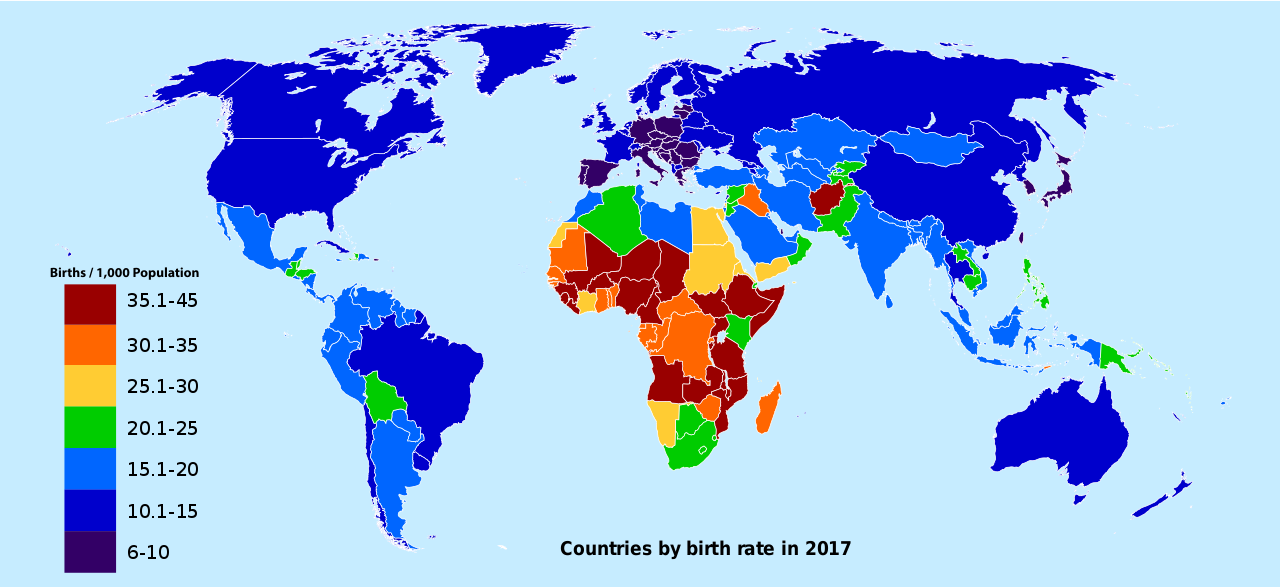
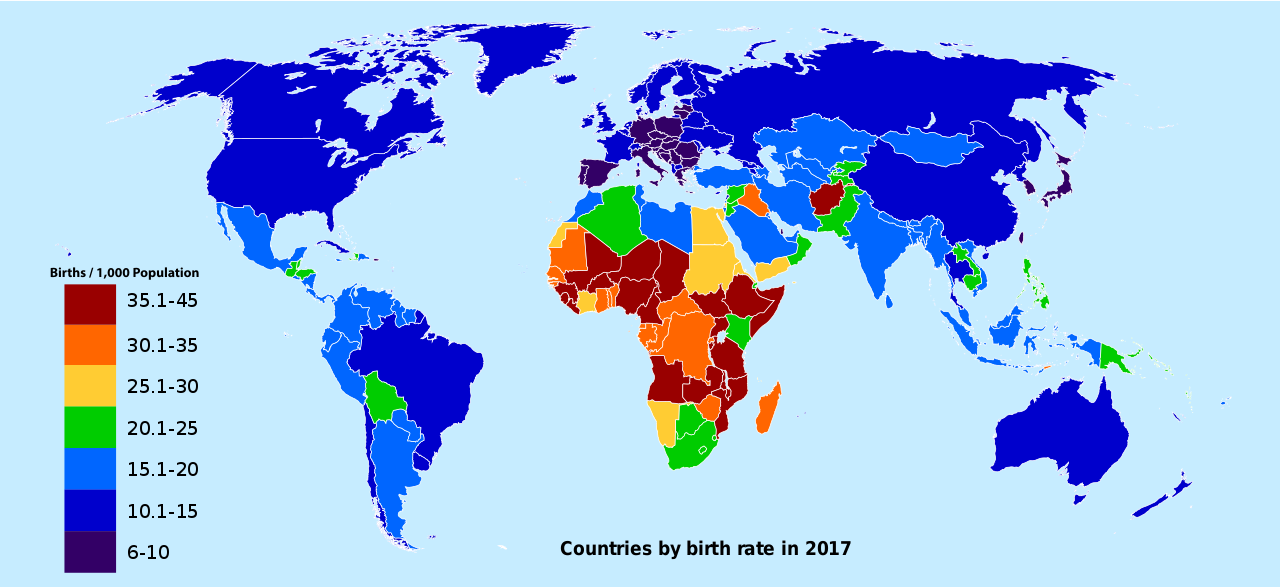

<div align="center" style="margin-bottom: -10px;"><font size="4"><strong>Birth Rate World Maptttt</strong></font></div>

<div align="center"><font size="4"><strong>Birth Rate World Map</strong></font>
<img src="Birth_rate_world_map.PNG" width="750" /><p>  </p></div>

<div align="center"><font size="4"><strong>Birth Rate World Map</strong></font>
<img src="Serbia - Crude birth rate.png" width="750" /><p>  </p></div>

![Han Solo]("Birth_rate_world_map.jpg")
<div align="center"><font size="4"><strong>Han Solo</strong></font></div>

In [60]:
%%sql
SELECT name, birth_rate AS bottom20_birth_rate
  FROM facts
WHERE birth_rate NOT NULL
ORDER BY birth_rate
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,bottom20_birth_rate
Monaco,6.65
Saint Pierre and Miquelon,7.42
Japan,7.93
Andorra,8.13
"Korea, South",8.19
Singapore,8.27
Slovenia,8.42
Germany,8.47
Taiwan,8.47
San Marino,8.63


The <u>lowest birth rate</u>, up to 7 births per 1,000 persons, is observed in 
<strong>Western Europe</strong> (Monaco, Andorra, Germany, Greece, Italy, Portugal), <strong>some small countries and islands </strong>(Saint Pierre and Miquelon, Singapore, Taiwan, San-Marino, Macao, Hong Kong), <strong>Japan</strong>, <strong>South Korea</strong>, and <strong>Eastern Europe</strong> (Slovenia, Bosnia and Herzegovina, Bulgaria, Serbia, Romania, Hungary).

This time the list of countries doesn't look so obvious, especially the TOP5 countries. Google search, in particular [Knoema data source](https://knoema.com), gives us some graphs showing that the birth rate decline is an evident tendency for these countries for already many years, and seemingly still continuing (in the end of 2020).

<div align="center"><font size="4"><strong>Monaco Birth Rate</strong></font>
<img src="images/Monaco_birth_rate.JPG" width="500"><p>  </p></div>

<div align="center"><font size="4"><strong>Japan Birth Rate</strong></font>
<img src="Japan_birth_rate.jpg" width="500"><p>  </p></div>

<div align="center"><font size="4"><strong>Andorra Birth Rate</strong></font>
<img src="Andorra_birth_rate.jpg" width="500"><p>  </p></div>

<div align="center"><font size="4"><strong>South Korea Birth Rate</strong></font>
<img src="South_Korea_birth_rate.jpg" width="500"><p>  </p></div>

Additionally, this [Wikipedia article](https://en.wikipedia.org/wiki/Birth_rate) throws a light on the reasons for such a situation in Japan:
>As of 2016, Japan has the third lowest crude birth rate (i.e. not allowing for the population's age distribution) in the world, with only Saint Pierre and Miquelon and Monaco having lower crude birth rates. Japan has an unbalanced population with many elderly but few young people, and this is projected to be more extreme in the future, unless there are major changes. An increasing number of Japanese people are staying unmarried: between 1980 and 2010, the percentage of the population who had never married increased from 22% to almost 30%, even as the population continued to age, and by 2035 one in four people will not marry during their childbearing years. The Japanese sociologist Masahiro Yamada coined the term "parasite singles" for unmarried adults in their late 20s and 30s who continue to live with their parents.

Now, let's have a look at the death rate.

In [61]:
%%sql
SELECT name, death_rate AS top20_death_rate
  FROM facts
ORDER BY death_rate DESC
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,top20_death_rate
Lesotho,14.89
Ukraine,14.46
Bulgaria,14.44
Guinea-Bissau,14.33
Latvia,14.31
Chad,14.28
Lithuania,14.27
Namibia,13.91
Afghanistan,13.89
Central African Republic,13.8


The <u>highest death rate</u>, up to 15 deaths per 1,000 persons, is observed in <strong>African countries</strong>, 
<strong>Eastern Europe</strong> (Ukraine, Bulgaria, Serbia, Belarus, Hungary), <strong>Baltic countries</strong>, <strong>Afganistan</strong>, and <strong>Russia</strong>. We see that despite African countries strongly dominate also this list, the birth rate in all of them is much higher, which results in the the highest values of the population growth in them. For the countries of Eastern Europe, high death rates, together with low birth rates, lead to low values of the population growth.      

Anyway, while African countries are notoriously famous for their high death rates (as well as their birth rates), the presence of Ukraine, Bulgaria, and Latvia among the TOP5 countries in this list looks unexpected. In this [Wikipedia article](https://en.wikipedia.org/wiki/Mortality_rate) we find a map of the death rate worldwide, which confirms our conclusions.

<div align="center"><font size="4"><strong>Death Rate World Map</strong></font>
<img src="Death_rate_world_map.png" width="800"><p>  </p></div>

One of the main factors of this phenomenon, according to the article, is national income, which is directly tied to standard of living within a country.
In addition, it is mentioned that mortality rates are affected by short term price increases. 

In particular, according to the Wikipedia page for [Ukraine](https://en.wikipedia.org/wiki/Ukraine), the reasons for such a high death rate in this country are major public health issues, alcoholism and smoking among working-age males, obesity, systemic high blood pressure and the HIV endemic. For [Bulgaria](https://en.wikipedia.org/wiki/Bulgaria), the demographic crisis and high death rate result from a combination of an ageing population, a high number of people at risk of poverty, a weak healthcare system, the emigration of doctors due to low wages, understaffed and under-equipped regional hospitals, supply shortages. As for the Baltic countries, [The Baltic Times](https://www.baltictimes.com/baltic_countries__mortality_rates_considerably_higher_than_european_average/) mentions diseases of the circulatory system, cancer and injuries as the main causes of high death rates.

The graphs from [Knoema](https://knoema.com) confirm that the tendency for these countries has been continuing for many years.

<div align="center"><font size="4"><strong>Ukraine Death Rate</strong></font>
<img src="Ukraine_death_rate.jpg" width="500"><p>  </p></div>

<div align="center"><font size="4"><strong>Bulgaria Death Rate</strong></font>
<img src="Bulgaria_death_rate.jpg" width="500"><p>  </p></div>

<div align="center"><font size="4"><strong>Latvia Death Rate</strong></font>
<img src="Latvia_death_rate.jpg" width="500"><p>  </p></div>

Next, we'll explore the BOTTOM20 countries by death rate.

In [62]:
%%sql
SELECT name, death_rate AS bottom20_death_rate
  FROM facts
WHERE death_rate NOT NULL
ORDER BY death_rate
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,bottom20_death_rate
Qatar,1.53
United Arab Emirates,1.97
Kuwait,2.18
Bahrain,2.69
Gaza Strip,3.04
Turks and Caicos Islands,3.1
Saudi Arabia,3.33
Oman,3.36
Singapore,3.43
West Bank,3.5


The <u>lowest death rates</u>, up to 2 deaths per 1,000 persons, are mostly related to the <strong>Middle East countries</strong>, which are historically characterized by a very high standard of living.

Now, let's investigate another demografic indicator: the natural increase, i.e. the difference between the birth and death rates.

In [63]:
%%sql
SELECT name, ROUND(birth_rate - death_rate, 1) AS top20_natural_increase
  FROM facts
WHERE death_rate NOT NULL AND birth_rate NOT NULL
ORDER BY top20_natural_increase DESC
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,top20_natural_increase
Malawi,33.2
Uganda,33.1
Niger,33.0
Burundi,32.7
Mali,32.1
Burkina Faso,30.3
Zambia,29.5
Ethiopia,29.1
South Sudan,28.7
Tanzania,28.4


As we could expect from the population growth and birth rate trends, in <strong>African countries</strong> the <u>birth rate strongly exceeds the death rate</u>. In addition, a high natural increase is observed in <strong>Iraq</strong>.

In [64]:
%%sql
SELECT name, ROUND(birth_rate - death_rate, 1) AS bottom20_natural_increase
  FROM facts
WHERE death_rate NOT NULL AND birth_rate NOT NULL
ORDER BY bottom20_natural_increase
LIMIT 20;

 * sqlite:///factbook.db
Done.


name,bottom20_natural_increase
Bulgaria,-5.5
Serbia,-4.6
Latvia,-4.3
Lithuania,-4.2
Ukraine,-3.7
Hungary,-3.6
Germany,-3.0
Slovenia,-3.0
Romania,-2.8
Belarus,-2.7


As for the <u>lowest natural increase</u>, which being negative is practically a decrease here, not surprisingly, we see again the same countries of <strong>Eastern Europe</strong>, suffering from the demographic crisis (Bulgaria, Serbia, Ukraine, Hungary, Slovenia, Romania, Belarus, Croatia, Bosnia and Herzegovina), <strong>Baltic countries</strong>, <strong>Western Europe</strong> (Germany, Monaco, Greece, Portugal, Italy), <strong>Saint Pierre and Miquelon</strong>, which was at the 2nd place among the BOTTOM20 countries by birth rate, <strong>Russia</strong>, and <strong>Japan</strong>. 

Serbia at the 2nd place looks curious, we have never encountered it in any TOP5 or BOTTOM5 lists. Let's look at it in more detail.

<div align="center"><font size="4"><strong>Serbia Birth Rate</strong></font>
<img src="Serbia_birth_rate.jpg" width="500"><p>  </p></div>

<div align="center"><font size="4"><strong>Serbia Death Rate</strong></font>
<img src="Serbia_death_rate.jpg" width="500"><p>  </p></div>

Both [Knoema](https://knoema.com/atlas/Serbia) and [Wikipedia](https://en.wikipedia.org/wiki/Serbia) confirm that Serbia has been suffering a heavy demographic crisis since the beginning of the 1990s, with a death rate continuously exceeding the birth rate. This country has low life expectancy, one of the oldest populations in the world, and it is shrinking at one of the fastest rates in the world.

Lastly, let's find the average birth and death rates, and the natural increase in the world.

In [65]:
%%sql
SELECT ROUND(AVG(birth_rate), 1) AS average_birth_rate,
       ROUND(AVG(death_rate), 1) AS average_death_rate,
       ROUND(AVG(birth_rate - death_rate), 1) AS average_natural_increase
    FROM facts;

 * sqlite:///factbook.db
Done.


average_birth_rate,average_death_rate,average_natural_increase
19.3,7.8,11.5


## Exploring Area Statistics
Let's find TOP5 and BOTTOM5 countries by area.

In [66]:
%%sql
SELECT name, area AS top5_area
  FROM facts
WHERE area NOT NULL
ORDER BY area DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,top5_area
Russia,17098242
Canada,9984670
United States,9826675
China,9596960
Brazil,8515770


The <u>biggest country</u> is <strong>Russia</strong>, followed with a big gap by <strong>Canada</strong>, the <strong>United States</strong>, <strong>China</strong>, and <strong>Brazil</strong>.

In [67]:
%%sql
SELECT name, area AS bottom5_area
  FROM facts
WHERE area NOT NULL
ORDER BY area
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,bottom5_area
Holy See (Vatican City),0
Monaco,2
Coral Sea Islands,3
Ashmore and Cartier Islands,5
Navassa Island,5


The <u>smallest country</u> is <strong>Vatican</strong>, followed by <strong>Monaco</strong> and 3 island groups.

Next, we're going to explore what countries have the highest ratio of water to land.

In [68]:
%%sql
SELECT name, area_water, area_land,
      ROUND(CAST(area_water AS Float)/ CAST(area_land AS Float), 1) AS water_to_land
    FROM facts
WHERE area_land != 0 
  AND area_water NOT NULL
ORDER BY water_to_land DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area_water,area_land,water_to_land
British Indian Ocean Territory,54340,60,905.7
Virgin Islands,1564,346,4.5
Puerto Rico,4921,8870,0.6
"Bahamas, The",3870,10010,0.4
Guinea-Bissau,8005,28120,0.3
Malawi,24404,94080,0.3
Eritrea,16600,101000,0.2
Liberia,15049,96320,0.2
Netherlands,7650,33893,0.2
Uganda,43938,197100,0.2


Apart from an obvious outlier British Indian Ocean Territory, we can see [other issues](https://en.wikipedia.org/wiki/Talk%3AList_of_countries_by_percentage_of_water_area) here. But first, let's look at the [definition of the water area](https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area):
><strong>Water area:</strong> the sum of the surface areas of all inland water bodies (lakes, reservoirs, and rivers) within international boundaries and coastlines. Coastal internal waters (some small bays) may be included. Territorial seas are not included unless otherwise noted. Contiguous zones and exclusive economic zones are not included.

Hence, there is definitely something wrong with our `area_water` data: for some countries, this area includes not only enclosed waters, as it is supposed to, but also [territorial waters](https://en.wikipedia.org/wiki/Territorial_waters#:~:text=The%20term%20territorial%20waters%20is,and%20potentially%20the%20continental%20shelf.) around the country and [coastal waters](http://www.wiser.eu/background/coastal-waters/#:~:text=Coastal%20waters%20represent%20the%20interface,where%20territorial%20waters%20are%20measured.) (like big gulfs). This can be easily seen on the Google maps below.

<div align="left"><font size="3"><strong>Territorial waters:</strong></font>
<img src="Puerto_Rico_Virgin_Islands.jpg" width="600" style="margin-top: 2px;">
<img src="Eritrea.jpg" width="370" style="margin-top: 7px;">
<img src="Liberia.jpg" width="360" style="margin-top: 7px;"></div>

<div align="left"><font size="3"><strong>Coastal waters (big gulfs and estuaries):</strong></font>
<img src="Bahamas.jpg" width="270" style="margin-top: 2px;">
<img src="Guinea_Bissau.jpg" width="400" style="margin-top: 7px;"></div>

So, of all the 10 territories from the table above (9, if not to count the outlier), we have only 3 countries with the real enclosed water area, characterized by <u>high water-to-land ratio</u>: <strong>Malawi</strong> (30%), <strong>Netheralds</strong> (20%), and <strong>Uganda</strong> (20%).

<img src="Malawi.jpg" width="220" style="margin-top: 7px;">
<img src="Uganda.jpg" width="300" style="margin-top: 7px;">
<img src="Netherlands.jpg" width="300" style="margin-top: 7px;">

In Malawi, the water area is mostly represented by Lake Malawi, in Uganda – by Lake Victoria, the biggest fresh-water lakes in Africa and ones of the biggest in the world. In Netherlands, the main water area is represented by two giant artificial fresh-water lakes Markermeer and IJsselmeer.  
## Conclusion
In this project, we have analyzed various demographic and geographic statistics for all the countries in the world from the CIA World Factbook 2015. Below are our main findings.
- The countries with the biggest <strong>population</strong> are China, India, the United States, Indonesia, and Brazil. The least populated are some islands (Pitcairn, Niue, Tokelau, Cocos Islands) and Vatican.
- The highest <strong>population density</strong> is observed in Macau, Monaco, Singapore, and Hong Kong; from bigger countries – Bangladesh and South Korea. The lowest population density: Greenland and Svalbard; from bigger countries – Mongolia, Namibia, and Australia.
- <strong>Population dynamics</strong>:
  - <strong>African countries</strong> show the highest both birth and death rates. However, the birth rates are much higher, which results in the highest values of the natural increase and population growth in the world.
  - In <strong>Western Europe</strong>, the following countries demonstrate low birth rates: Monaco, Andorra, Germany, Greece, Italy, and Portugal. It leads to a negative natural increase, and, as a result, to a low population growth. However, in Germany and Italy the negative natural increase seems to be compensated by the immigration, hence the population growth for them is not among the lowest ones. 
  - In many <strong>Eastern Europe</strong> and <strong>Baltic countries</strong>, a negative natural increase is observed. In some of them (Bosnia and Herzegovina, Slovenia, Romania) it is explained by low birth rates, in some other (Ukraine, Belarus, Baltic countries) – by high death rates; finally, in the others (Bulgaria, Serbia, Hungary) both low birth rates and high death rates take place. 
  - All the countries of the <strong>Middle East</strong> show the lowest death rates in the world.
  - <strong>Iraq</strong> is related to the countries with the highest birth rates, which leads to a high natural increase and population growth.
  - In <strong>Afganistan</strong>, both the birth and death rates are one of the highest in the world.
  - <strong>Japan</strong>, <strong>Saint Pierre and Miquelon</strong>, and <strong>South Korea</strong> have one of the lowest birth rates in the world, leading to a negative natural increase.
  - <strong>Russia</strong> has one of the higest death rates, leading to a negative natural increase and low population growth.
- <strong>Area</strong>. The biggest countries are Russia, Canada, the United States, China, and Brazil. The smallest ones: Vatican and Monaco.
- <strong>Water area</strong>. The countries characterized by the highest water-to-land ratio, considering only enclosed fresh waters: Malawi (Lake Malawi), Netherlands (artificial lakes Markermeer and IJsselmeer), and Uganda (Lake Victoria).